In [1]:
import os, re
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

In [2]:
os.chdir('..')

---

In [566]:
df = pd.read_stata(os.path.join(os.getcwd(), '3_pipeline', '1_intermediate', 'sample_for_cohort_formation.dta'))

In [567]:
cohort_df = pd.read_stata(os.path.join(os.getcwd(), '3_pipeline', '1_intermediate', 'sample_cohorts.dta'))
treated = cohort_df.loc[cohort_df['treated'] == 1, ['gvkey', 'fyear']].drop_duplicates()
treated['treated'] = 1
control = cohort_df.loc[cohort_df['treated'] == 0, ['gvkey', 'fyear']].drop_duplicates()
control['control'] = 1
df = df.merge(right = treated, on = ['gvkey', 'fyear'], how = 'left')
df = df.merge(right = control, on = ['gvkey', 'fyear'], how = 'left')
# a firm can be a control in an earlier cohort and then become treated in a later cohort
# don't include such firms twice; exclude altogether
df = df.loc[~((df['treated'] == 1) & (df['control'] == 1))]

In [568]:
df = df.loc[df['fyear'] >= 2012]

In [569]:
df['cum3loss'] = np.where(df['ib_sum'] < 0, 1, 0)

In [570]:
df['indefinite'] = np.where(df['tlcf_indefin'] > 0.75, 1, 0)
df['indefinite'] = df.groupby('gvkey')['indefinite'].transform('max')

In [571]:
df['1'] = np.where(df['dta_ratio'] == 1, 1, 0)
df['0.80-0.99'] = np.where((df['dta_ratio'] >= 0.80) & (df['dta_ratio'] < 1), 1, 0)
df['0.60-0.79'] = np.where((df['dta_ratio'] >= 0.60) & (df['dta_ratio'] < 0.80), 1, 0)
df['0.40-0.59'] = np.where((df['dta_ratio'] >= 0.40) & (df['dta_ratio'] < 0.60), 1, 0)
df['0.20-0.39'] = np.where((df['dta_ratio'] >= 0.20) & (df['dta_ratio'] < 0.40), 1, 0)
df['0.01-0.19'] = np.where((df['dta_ratio'] > 0.00) & (df['dta_ratio'] < 0.20), 1, 0)
df['0'] = np.where(df['dta_ratio'] == 0.00, 1, 0)

In [511]:
df.loc[(df['0.60-0.69'] == 1) & (df['cum3loss'] == 1)]

,gvkey,fyear,consol,indfmt,datafmt,popsrc,curcd,costat,at,lt,...,0.80-0.89,0.70-0.79,0.60-0.69,0.50-0.59,0.40-0.49,0.30-0.39,0.20-0.29,0.10-0.19,0.01-0.09,0
58,1559,2022.0,C,INDL,STD,D,USD,A,43.956,18.331,...,0,0,1,0,0,0,0,0,0,0
93,1613,2019.0,C,INDL,STD,D,USD,A,506.560,450.944,...,0,0,1,0,0,0,0,0,0,0
94,1613,2020.0,C,INDL,STD,D,USD,A,463.208,378.209,...,0,0,1,0,0,0,0,0,0,0
95,1613,2021.0,C,INDL,STD,D,USD,A,485.632,393.826,...,0,0,1,0,0,0,0,0,0,0
152,1706,2019.0,C,INDL,STD,D,USD,A,1124.274,823.095,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15561,264387,2016.0,C,INDL,STD,D,USD,A,707.961,192.934,...,0,0,1,0,0,0,0,0,0,0
15562,264387,2017.0,C,INDL,STD,D,USD,A,705.472,162.877,...,0,0,1,0,0,0,0,0,0,0
15622,315318,2018.0,C,INDL,STD,D,USD,A,9401.500,7220.400,...,0,0,1,0,0,0,0,0,0,0
15623,315318,2019.0,C,INDL,STD,D,USD,A,4324.400,2105.100,...,0,0,1,0,0,0,0,0,0,0


In [601]:
df.loc[(df['treated'] == 1)].groupby(['fyear', 'cum3loss']).size()

fyear   cum3loss
2015.0  0            18
        1             7
2016.0  0            53
        1            14
2017.0  0           109
        1            57
2018.0  0           187
        1           130
2019.0  0           244
        1           237
2020.0  0           233
        1           351
2021.0  0           257
        1           417
2022.0  0           249
        1           547
2023.0  0           169
        1           335
dtype: int64

<Axes: xlabel='fyear'>

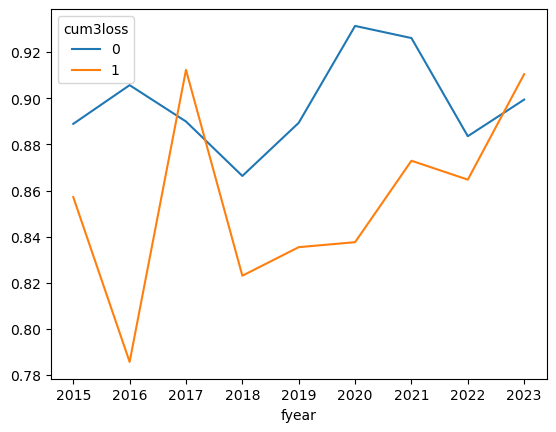

In [598]:
df.loc[(df['treated'] == 1)].groupby(['fyear', 'cum3loss'])['partial'].mean().unstack().plot()

In [376]:
indefinite = df.loc[df['indefinite'] == 1]
definite = df.loc[df['indefinite'] == 0]

<Axes: xlabel='fyear'>

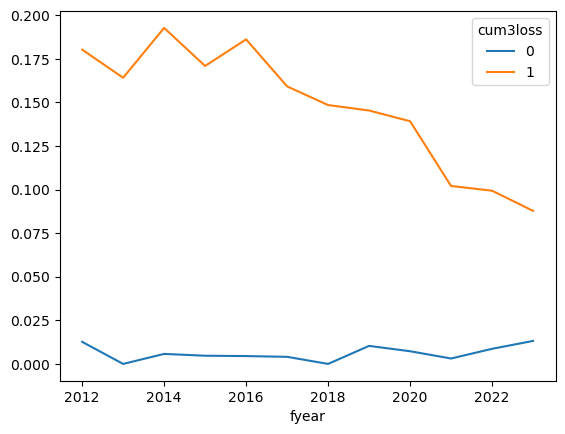

In [377]:
indefinite.groupby(['fyear', 'cum3loss'])['full'].mean().unstack().plot()

<Axes: xlabel='fyear'>

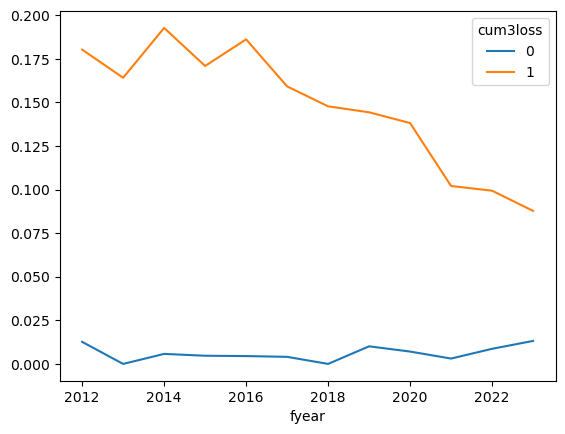

In [275]:
indefinite.groupby(['fyear', 'cum3loss'])['full'].mean().unstack().plot()

In [11]:
df['full_'] = np.where((df['dta_ratio'] >= 0.95) & (df['fyear'].isin([2017, 2018])), 1, 0)

In [15]:
df['partial_post'] = np.where((df['dta_ratio'] < 0.95) &
                              (df['dta_ratio'] >= 0.05) &
                              (df['fyear'] > 2018), 1, 0)

In [18]:
df[['full_pre', 'partial_post']] = df.groupby('gvkey')[['full_pre', 'partial_post']].transform('max')

In [31]:
df.loc[(df['full_pre'] == 1) & (df['partial_post'] == 1), 'gvkey'].unique()

array([  4418,   5831,   5888,   6158,   6848,   8599,   9023,   9551,
        10938,  12711,  12719,  12818,  14320,  14603,  14793,  15044,
        17199,  18009,  18159,  18430,  18556,  18561,  18562,  18630,
        18899,  18938,  19044,  19149,  19175,  19470,  19534,  19602,
        19753,  19773,  19849,  19908,  20088,  20229,  20961,  21006,
        21015,  21020,  21232,  21238,  21282,  22000,  22182,  22590,
        23407,  23555,  23810,  23818,  23865,  23990,  24005,  24084,
        24176,  24177,  24501,  24658,  24996,  25740,  25756,  26045,
        26069,  26112,  26146,  26341,  26367,  26636,  26892,  26908,
        27155,  27199,  27318,  27354,  27387,  27392,  27476,  27703,
        27737,  27925,  28087,  28367,  29127,  29621,  29680,  30137,
        30220,  31405,  31457,  31624,  32382,  32526,  61285,  61587,
        61971,  62262,  62516,  62525,  62553,  62666,  63700,  64334,
        65021,  65552,  65732,  65899,  66697, 110760, 112759, 119574,
      

In [53]:
df.loc[df['gvkey'] == 18556, ['gvkey', 'hcik', 'name', 'fyear', 'va', 'dta_ratio',
                                                           'tlcf_pre_2018', 'tlcf_post_2018', 'tlcf_indefin',
                                                           'ib_sum']]

,gvkey,hcik,name,fyear,va,dta_ratio,tlcf_pre_2018,tlcf_post_2018,tlcf_indefin,ib_sum
4329,18556,1364954.0,"CHEGG, INC",2015.0,98.209,0.998384,279.0,0.0,0.000000,-179.818
4330,18556,1364954.0,"CHEGG, INC",2016.0,110.045,0.997679,352.2,0.0,0.000000,-166.213
4331,18556,1364954.0,"CHEGG, INC",2017.0,91.183,0.984559,452.0,0.0,0.000000,-121.738
4332,18556,1364954.0,"CHEGG, INC",2018.0,125.844,0.967079,452.0,193.0,0.299225,-77.416
4333,18556,1364954.0,"CHEGG, INC",2019.0,148.519,0.812752,452.0,579.0,0.561591,-44.776
4334,18556,1364954.0,"CHEGG, INC",2020.0,151.825,0.716568,452.0,733.0,0.618565,-30.714
4335,18556,1364954.0,"CHEGG, INC",2021.0,238.317,0.972587,412.0,733.0,0.640175,-17.284
4336,18556,1364954.0,"CHEGG, INC",2022.0,36.122,0.159354,88.6,733.0,0.892162,258.959
4337,18556,1364954.0,"CHEGG, INC",2023.0,40.162,0.205954,0.0,496.0,1.000000,283.360


In [28]:
df.loc[(df['full_pre'] == 1) & (df['partial_post'] == 1), ['gvkey', 'fyear', 'va', 'dta_ratio',
                                                           'tlcf_pre_2018', 'tlcf_post_2018', 'tlcf_indefin',
                                                           'ib_sum']]

,gvkey,fyear,va,dta_ratio,tlcf_pre_2018,tlcf_post_2018,tlcf_indefin,ib_sum
938,4418,2013.0,47.623,0.986249,106.2,0.0,0.000000,-70.466
939,4418,2014.0,49.465,0.984672,109.2,0.0,0.000000,-67.483
940,4418,2015.0,49.658,0.983716,112.9,0.0,0.000000,-30.499
941,4418,2016.0,34.912,0.977051,62.9,0.0,0.000000,33.024
942,4418,2017.0,32.581,0.972596,65.5,0.0,0.000000,40.497
...,...,...,...,...,...,...,...,...
15544,264265,2019.0,1046.013,0.939182,3020.0,1480.0,0.328889,-2138.487
15545,264265,2020.0,1349.729,0.898646,2420.0,1480.0,0.379487,-2505.894
15546,264265,2021.0,1808.992,0.928252,2420.0,2880.0,0.543396,-2597.221
15547,264265,2022.0,2193.633,0.955914,2420.0,3633.3,0.600218,-2842.261


create 2 digit SIC groups

In [5]:
df['sic_group'] = np.floor(df['hsic'] / 100).astype('Int64')

create loss sequence variable

In [6]:
# first create variable to check whether years are consecutive
df['L1_fyear'] = df.groupby('gvkey')['fyear'].shift(1)
df['is_year_cons'] = np.where((df['fyear'] - df['L1_fyear']) == 1, 1, 0)

In [7]:
out = []
loss_count = 0

for i, r in df.iterrows():
    if r['is_year_cons'] == 0:
        loss_count = 0
    elif pd.isnull(r['ib']):
        loss_count = 0
    elif r['ib'] >= 0:
        loss_count = 0
    elif r['ib'] < 0:
        loss_count += 1
    
    # only append from second loss onwards (otherwise 'sequential' doesn't really make sense?)
    # and: there is also a firstloss dummy in the data that captures the first instance of a loss
    loss_count_to_append = 0 if loss_count == 1 else loss_count
    
    out.append(loss_count_to_append)

In [8]:
df['lossseq'] = out

In [9]:
# the way the code above is set up, when ib is missing, lossseq = 0;
# set those observations to NA because we don't know really what ib in these cases
# so we can't conclude it should be a loss sequence of zero
df['lossseq'] = np.where(df['ib'].isna(), np.nan, df['lossseq'])

In [10]:
df.to_stata(os.path.join(os.getcwd(), '3_pipeline', '1_intermediate', 'sample.dta'),
            write_index = False)

---